# Transfer units

Different acute stroke units provide different services. Most provide intravenous thrombolysis (IVT) and a few provide mechanical thrombectomy (MT).

If a patient with a stroke needs mechanical thrombectomy but has been taken to a stroke unit that doesn't provide it, they can receive a transfer to another stroke unit that does provide it.

This notebook shows how the `stroke-maps` package can find each stroke unit's selected transfer unit. To do this, it needs a dataframe of stroke units and their services. 

The first step in the calculation is to find the closest unit offering MT to each other stroke unit. There is also an option to overwrite the default closest unit for chosen units.

Assumptions:
+ The stroke units considered must be in the travel time matrix. _TO DO_: make a map or something to show which ones. For now the list can be found from the dataframe.

## Notebook setup

In [1]:
import stroke_maps.load_data
import stroke_maps.catchment  # to link units to transfer units.
import stroke_maps.geo  # to create transfer unit geometry to plot.

import pandas as pd
import matplotlib.pyplot as plt

## Load the stroke unit data

We import the data from the package files. The imported dataframe, `df_units`, contains only units that appear in the travel time matrix. This includes units that are not acute stroke units (i.e. provide neither thrombolysis nor thrombectomy).

In [2]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

# Reduce this to only the few columns that we need for this demo:
columns_to_keep = [
    'stroke_team',  # These two name columns aren't needed but
    'ssnap_name',   # they are easier to read than postcodes.
    'use_ivt',
    'use_mt',
    'transfer_unit_postcode',
    'country'  # not needed but used for an example in this notebook.
]
df_units = df_units[columns_to_keep]

df_units.head(3)

,stroke_team,ssnap_name,use_ivt,use_mt,transfer_unit_postcode,country
postcode,,,,,,
SY231ER,Bronglais Hospital (Aberystwyth),Bronglais Hospital,1,0,nearest,Wales
CB20QQ,"Addenbrooke's Hospital, Cambridge",Addenbrooke's Hospital,1,1,nearest,England
L97AL,"University Hospital Aintree, Liverpool",University Hospital Aintree,1,1,nearest,England


Explanations of the columns:
+ `use_ivt`: whether this stroke unit provides IVT. The value is 1 (one) if it does, and 0 (zero) if it doesn't.
+ `use_mt`: whether this stroke unit provides MT. The value is 1 (one) if it does, and 0 (zero) if it doesn't.
+ `transfer_unit_postcode`: optional column for overwriting the transfer units returned by the calculation. The value is `nearest` if the function should use the nearest transfer unit, or the postcode of the transfer unit that you would like to use instead.

## Find the transfer units

The transfer units are found in the following function:

In [3]:
df_transfer = stroke_maps.catchment.calculate_transfer_units(df_units)

In [4]:
df_transfer

,transfer_unit_travel_time,transfer_unit_postcode
postcode,,
SY231ER,135.8,CF144XW
CB20QQ,0.0,CB20QQ
L97AL,0.0,L97AL
CH495PE,27.3,L97AL
BA13NG,33.7,BS105NB
...,...,...
SL24HL,NaN,<NA>
HP112TT,34.8,OX39DU
BA214AT,74.5,BS105NB


Notes:
+ The index column has the same contents as the index of the input units dataframe (`df_units`).
+ When the transfer unit is the same as the starting unit, the travel time is zero.
+ When the starting unit is not an acute stroke unit, the transfer unit postcode is `pd.NA` (pandas missing value, displays as '\<NA\>') and the travel time is `NaN` (numpy Not A Number).

## How does the function work?

__TO DO__ write me please

## Example 1: removing certain units

To remove certain units from this calculation, just remove them from the input `df_units` dataframe.

The default setup means that some stroke units will transfer their patients across countries. Add some columns to the transfer dataframe to show this:

In [5]:
# Merge in the country for the starting unit:
df_country = pd.merge(
    df_transfer, df_units['country'],
    left_index=True, right_index=True, how='left'
)
df_country = df_country.rename(columns={'country': 'country_start'})
# Merge in the country for the transfer unit:
df_country = pd.merge(
    df_country, df_units['country'],
    left_on='transfer_unit_postcode', right_index=True, how='left'
)
df_country = df_country.rename(columns={'country': 'country_end'})

# Find units where the start and end countries don't match:
mask = df_country['country_start'] != df_country['country_end']

# Show these units.
# Drop NA to not display units that don't have a transfer unit.
df_country[mask].dropna()

,transfer_unit_travel_time,transfer_unit_postcode,country_start,country_end
postcode,,,,
LL185UJ,67.0,L97AL,Wales,England
HR12ER,72.4,CF144XW,England,Wales
LL137TD,54.1,L97AL,Wales,England
LL572PW,103.5,L97AL,Wales,England


Patients will be transferred to Cardiff (CF144XW) from Hereford (HR12ER), and patients will be transferred to Liverpool (L97AL) from Rhyl (LL185UJ), Wrexham (LL137TD), and Bangor (LL572PW).

One option for avoiding this is to remove the Welsh hospitals entirely and perform the calculation for only English stroke units. Then later, do the opposite and have two sets of results.

Reload the list of stroke units and pick out any in Wales:

In [6]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

In [7]:
postcodes_in_wales = df_units[df_units['country'] == 'Wales'].index.values

postcodes_in_wales

array(['SY231ER', 'CF144XW', 'LL185UJ', 'NP448YN', 'LL137TD', 'SA66NL',
       'CF479DT', 'SA148QF', 'CF311RQ', 'NP202UB', 'SA612PZ', 'SA312AF',
       'LL572PW'], dtype=object)

Now keep only the rows of the dataframe that are not in that list of Welsh postcodes:

In [8]:
# How many stroke teams are in the list now?
len(df_units)

141

In [9]:
# Mask is True when the stroke unit is in Wales.
mask = df_units.index.isin(postcodes_in_wales)

# Include the "~" tilde to take everything in the mask that is _not_ True:
df_units = df_units[~mask]

In [10]:
# How many stroke teams are in the list now?
len(df_units)

128

Now calculate the transfer units:

In [11]:
df_transfer = stroke_maps.catchment.calculate_transfer_units(df_units)

Copy the exact same code from before to check the countries before and after:

In [12]:
# Merge in the country for the starting unit:
df_country = pd.merge(
    df_transfer, df_units['country'],
    left_index=True, right_index=True, how='left'
)
df_country = df_country.rename(columns={'country': 'country_start'})
# Merge in the country for the transfer unit:
df_country = pd.merge(
    df_country, df_units['country'],
    left_on='transfer_unit_postcode', right_index=True, how='left'
)
df_country = df_country.rename(columns={'country': 'country_end'})

# Find units where the start and end countries don't match:
mask = df_country['country_start'] != df_country['country_end']

# Show these units.
# Drop NA to not display units that don't have a transfer unit.
df_country[mask].dropna()

,transfer_unit_travel_time,transfer_unit_postcode,country_start,country_end
postcode,,,,


This dataframe is empty because no stroke units are transferred to another stroke unit in a different country.

## Example 2: overwriting the nearest transfer unit

To force patients from Royal Devon & Exeter to be transferred to Bristol, we first look up the postcodes of those units:

In [13]:
df_units[((df_units['stroke_team'].str.contains('Exeter')) |
          (df_units['stroke_team'].str.contains('Bristol')))][columns_to_keep]

,stroke_team,ssnap_name,use_ivt,use_mt,transfer_unit_postcode,country
postcode,,,,,,
BS28HW,Bristol Royal Infirmary,University Hospitals Bristol Inpatient Team,0,0,nearest,England
EX25DW,Royal Devon and Exeter Hospital,Royal Devon and Exeter Hospital,1,0,nearest,England
BS105NB,North Bristol Hospital (Southmead),North Bristol Hospitals,1,1,nearest,England


Have a quick check of where patients in Exeter were transferred to before:

In [14]:
df_transfer.loc['EX25DW']

transfer_unit_travel_time      59.5
transfer_unit_postcode       PL68DH
Name: EX25DW, dtype: object

Then in the stroke unit dataframe, we update the `transfer_unit_postcode` column for the 'EX25DW' (Exeter) row. We set the value to 'BS105NB' for Bristol.

In [15]:
df_units.loc['EX25DW', 'transfer_unit_postcode'] = 'BS105NB'

Check that this updated:

In [16]:
df_units.loc['EX25DW', columns_to_keep]

stroke_team               Royal Devon and Exeter Hospital
ssnap_name                Royal Devon and Exeter Hospital
use_ivt                                                 1
use_mt                                                  0
transfer_unit_postcode                            BS105NB
country                                           England
Name: EX25DW, dtype: object

Now calculate the transfer units:

In [17]:
df_transfer = stroke_maps.catchment.calculate_transfer_units(df_units)

And check the result for Exeter:

In [18]:
df_transfer.loc['EX25DW']

transfer_unit_travel_time       90.6
transfer_unit_postcode       BS105NB
Name: EX25DW, dtype: object

## Plot the transfer unit links

Load in the default units data and create the transfer unit data:

In [19]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()
df_transfer = stroke_maps.catchment.calculate_transfer_units(df_units)

Create a GeoDataFrame of Line objects connecting each start unit to its transfer unit:

In [20]:
gdf_transfer = stroke_maps.geo.make_geometry_transfer_units(df_transfer)

First load the outline of England and Wales:

In [21]:
gdf_ew = stroke_maps.load_data.englandwales_outline()

Then load in the stroke unit coordinates:

In [22]:
gdf_units = stroke_maps.load_data.stroke_unit_coordinates()

Merge in the unit services information:

In [23]:
gdf_units = pd.merge(
    gdf_units, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

Plot the country outlines and the unit locations using matplotlib:

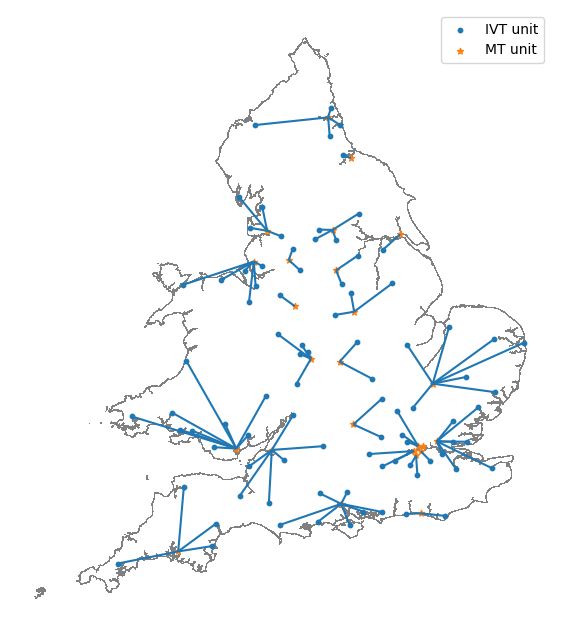

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the country outlines:
gdf_ew.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    facecolor='none',
    edgecolor='grey',
    linewidth=0.2,
    )

# Lines between units:
gdf_transfer.plot(ax=ax)

# Pick out which stroke units to plot:
mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
mask_mt = (gdf_units['use_mt'] == 1)

# IVT units:
ax.scatter(
    gdf_units.loc[mask_ivt, 'geometry'].x,
    gdf_units.loc[mask_ivt, 'geometry'].y,
    marker='o',
    label='IVT unit',
    s=10,  # size
    )

# MT units:
ax.scatter(
    gdf_units.loc[mask_mt, 'geometry'].x,
    gdf_units.loc[mask_mt, 'geometry'].y,
    marker='*',
    label='MT unit',
    s=20,  # size
    )

# Remove the axis border, ticks, labels...
ax.axis('off')

# Add legend:
ax.legend()

plt.show()